# 第四章 图像生成应用程序

## 一、背景知识

本章我们将学习如何利用 Gradio 制作一个简单的图像生成应用程序。如下图所示，我们将使用 `diffusers` 库中的 Stable Diffusion 模型（`runwayml\stable-diffusion-v1-5`）。比如，输入“一只站在太空针（美国西雅图一建筑）上的红色的鸟”，我们将会得到右侧的输出图片。

![Diffusion Model](images/ch06_4_1_Diffusion_Model.PNG)

与之前图片描述任务不同的是，这里我们将输入输出颠倒过来。如下图所示，我们先输入右侧的文字，然后得到左侧的图片。

![T2I](images/ch06_4_2_Text2Image.PNG)

## 二、 环境配置

加载 HF API 密钥和相关 Python 库

In [2]:
import os
import io
import IPython.display
from PIL import Image
import base64 
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
hf_api_key = os.environ['HF_API_KEY']

## 三、使用文本图像生成模型

在这里，我们将使用 `🧨 diffusers` 库运行 `runwayml/stable-diffusion-v1-5` 。

### 3.1 通过 HuggingFace API 调用
Stable Diffusion 模型相对较大，比较占用硬件资源。如果本地没有足够大的显卡，我们可以通过 HuggingFace 的 API 进行调用。

In [3]:
import requests, json

#加载文本图像生成模型
def get_completion(inputs, parameters=None, ENDPOINT_URL=os.environ['HF_API_TTI_BASE']):
    headers = {
      "Authorization": f"Bearer {hf_api_key}",
      "Content-Type": "application/json"
    }   
    data = { "inputs": inputs }
    if parameters is not None:
        data.update({"parameters": parameters})
        # 模型的调用函数
        response = requests.request("POST",
                                    ENDPOINT_URL,
                                    headers=headers,
                                    data=json.dumps(data))
    return json.loads(response.content.decode("utf-8"))

### 3.2 本地使用
如果本地的显卡能够支持 Stable Diffusion 的运行，可以使用 `diffusers` 库进行调用和运行。

In [ ]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5") # 加载 stable-diffusion-v1-5 模型

def get_completion(prompt):
    return pipeline(prompt).images[0]    

### 3.3 测试调用
下面我们对 API 的调用进行一下测试。输入“a dog in a park”，如果我们成功看到返回的图片，就证明 API 的调用成功了。
注意这个模型并不支持中文文本输入。


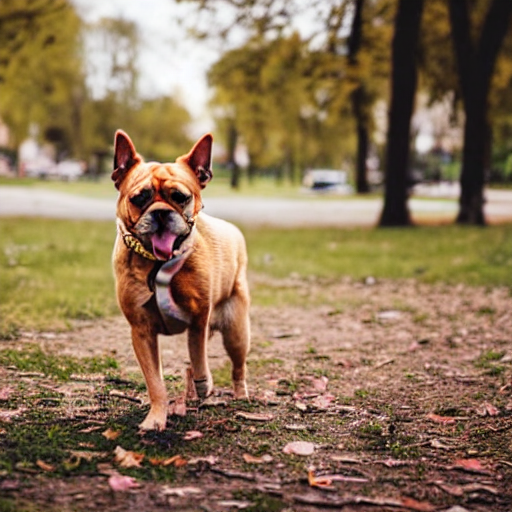

In [4]:
prompt = "a dog in a park" # 一直在公园里的狗 

result = get_completion(prompt)
IPython.display.HTML(f'<img src="data:image/png;base64,{result}" />')

## 四、通过`gr.Interface()`构建图片生成应用程序

### 4.1 构建一个基本的图像生成应用程序
当我们想要把上面的文本图像生成算法做成一个 demo 给其他人使用的时候，需要为用户制作一个简单好用的 GUI 界面。Gradio的出现大大简化了这个步骤。下面，我们将演示构建一个非常基本的图像生成应用程序，它有文本输入框、图像输出框等。

In [ ]:
import gradio as gr 

# 将 base64的字符串转换为 PIL 图片用于显示
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt):
    output = get_completion(prompt)
    result_image = base64_to_pil(output)
    return result_image

gr.close_all()
demo = gr.Interface(fn=generate,
                    inputs=[gr.Textbox(label="你的提示")],
                    outputs=[gr.Image(label="结果")],
                    title="基于 Stable Diffusion 的图片生成",
                    description="基于 Stable Diffusion 生成任意图片",
                    allow_flagging="never",
                    examples=["the spirit of a tamagotchi wandering in the city of Vienna","a mecha robot in a favela"])
# 例子解释：the spirit of a tamagotchi wandering in the city of Vienna 游荡在维也纳城的塔马戈蒂之魂
# 例子解释：a mecha robot in a favela 贫民窟里的机械机器人

demo.launch(share=True, server_port=int(os.environ['PORT1']))

运行上面的代码我们可以得到如下 GUI 界面。这里需要注意的是，我们使用的 Stable Diffusion 模型并不支持中文的 Prompt 输入。请使用英文输入 Prommpt，否则不会得到想要的图片。

![Image_Generation_with_Stable_Diffusion_CN](images/ch06_4_3_Image_Generation_with_Stable_Diffusion_CN.PNG)

In [ ]:
demo.close()

### 4.2 构建一个高级的图片生成程序
通过添加 “负面提示”，“推理步长”，“文字的引导程度”，“宽”，“高” 等，我们可以构建一个具备高级功能和更多交互功能的 GUI。

In [ ]:
import gradio as gr 

#A helper function to convert the PIL image to base64 
# so you can send it to the API
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt, negative_prompt, steps, guidance, width, height):
    params = {
        "negative_prompt": negative_prompt,
        "num_inference_steps": steps,
        "guidance_scale": guidance,
        "width": width,
        "height": height
    }
    
    output = get_completion(prompt, params)
    pil_image = base64_to_pil(output)
    return pil_image

gr.close_all()
demo = gr.Interface(fn=generate,
                    inputs=[
                        gr.Textbox(label="你的提示"),
                        gr.Textbox(label="负面提示"), # 你想要避免的内容
                        gr.Slider(label="推理步长（Inference Steps）", minimum=1, maximum=100, value=25,
                                 info="去噪器将分几步对图像进行去噪？"),
                        gr.Slider(label="文字的引导程度", minimum=1, maximum=20, value=7, 
                                  info="控制文字提示对结果的影响程度"),
                        gr.Slider(label="宽", minimum=64, maximum=512, step=64, value=512),
                        gr.Slider(label="高", minimum=64, maximum=512, step=64, value=512),
                    ],
                    outputs=[gr.Image(label="Result")],
                    title="基于 Stable Diffusion 的图片生成",
                    description="基于 Stable Diffusion 生成任意图片",
                    allow_flagging="never"
                    )

demo.launch(share=True, server_port=int(os.environ['PORT2']))

![Advanced](images/ch06_4_4_Advance.PNG)

In [ ]:
demo.close()

### 4.3 使用 `gr.Blocks()` 构建更高级的应用程序

#### 4.3.1 使用行列控制让排版更好看
使用 `gr.Blocks()` 我们可以通过 `gr.Row()` 和 `gr.Column()` 指定 GUI 中组件所在的具体位置。比如下面，我们将提示的输入放在了最上面的一排，然后将其他功能放在下排的左侧，将输出的结果放在右侧。

In [ ]:
gr.close_all()
with gr.Blocks() as demo:
    gr.Markdown("# 基于 Stable Diffusion 的图像生成")
    prompt = gr.Textbox(label="你的提示")
    with gr.Row(): # 行
        with gr.Column(): # 列
            negative_prompt = gr.Textbox(label="负面提示")
            steps = gr.Slider(label="推理步长（Inference Steps）", minimum=1, maximum=100, value=25,
                      info="去噪器将分几步对图像进行去噪？")
            guidance = gr.Slider(label="文字的引导程度", minimum=1, maximum=20, value=7,
                      info="控制文字提示对结果的影响程度")
            width = gr.Slider(label="宽", minimum=64, maximum=512, step=64, value=512)
            height = gr.Slider(label="高", minimum=64, maximum=512, step=64, value=512)
            btn = gr.Button("Submit")
        with gr.Column():
            output = gr.Image(label="Result")

    btn.click(fn=generate, inputs=[prompt,negative_prompt,steps,guidance,width,height], outputs=[output])
gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT3']))

![Block](images/ch06_4_4_Advance_2.png)

In [23]:
demo.close()

#### 4.3.2 添加可以隐藏的高级选项
因为有的时候我们并不需要使用某些功能，所以我们可以先将它们隐藏起来，在需要的时候再展开它们。这样会使得我们的 GUI 更加简洁。

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# 基于 Stable Diffusion 的图像生成")
    with gr.Row():
        with gr.Column(scale=4):
            prompt = gr.Textbox(label="你的提示") 
        with gr.Column(scale=1, min_width=50):
            btn = gr.Button("提交") # 提交按钮在另外一侧
    with gr.Accordion("高级选项", open=False): # 设置为False即默认隐藏高级选项，设置为True即默认显示高级选项
            negative_prompt = gr.Textbox(label="负面提示")
            with gr.Row():
                with gr.Column():
                    steps = gr.Slider(label="推理步长（Inference Steps）", minimum=1, maximum=100, value=25,
                              info="去噪器将分几步对图像进行去噪？")
                    guidance = gr.Slider(label="文字的引导程度", minimum=1, maximum=20, value=7,
                              info="控制文字提示对结果的影响程度")
                with gr.Column():
                    width = gr.Slider(label="宽", minimum=64, maximum=512, step=64, value=512)
                    height = gr.Slider(label="高", minimum=64, maximum=512, step=64, value=512)
    output = gr.Image(label="结果") 
            
    btn.click(fn=generate, inputs=[prompt,negative_prompt,steps,guidance,width,height], outputs=[output])

gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT4']))

![Advanced_Options_1](images/ch06_4_5_Advanced_Options_1.png)

当我们需要使用这些高级选项的时候，我们可以通过点击右侧的小三角展开它们。

![Advance_2](images/ch06_4_5_Advanced_Options_2.PNG)

In [ ]:
gr.close_all()